In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 12
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "tonguedetectiondataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1649 files belonging to 6 classes.


In [4]:
class_names = dataset.class_names
class_names

['hairytonguedataset',
 'healthytonguedataset',
 'leokoplakiatonguedataset',
 'oralcancerdataset',
 'orallichensdataset',
 'oralthrushdataset']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(12, 256, 256, 3)
[3 5 1 3 3 4 4 1 0 2 4 0]


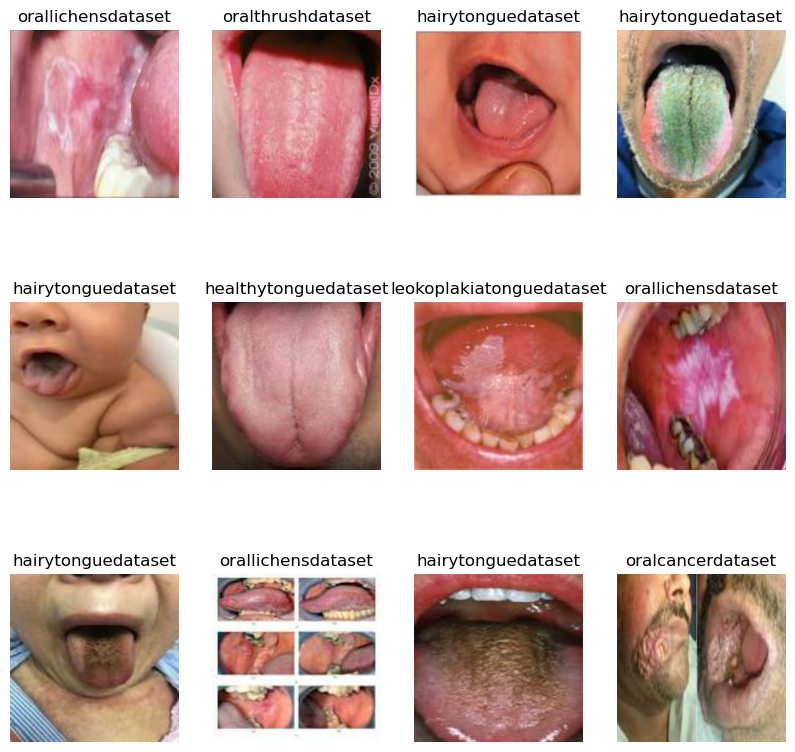

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

138

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

110

In [11]:
len(val_ds)

13

In [12]:
len(test_ds)

15

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [15]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"
                                                 ),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [16]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (12, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (12, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (12, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (12, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
110/110 [==============================] - 117s 1s/step - loss: 1.7816 - accuracy: 0.1935 - val_loss: 1.7612 - val_accuracy: 0.1987
Epoch 2/50
110/110 [==============================] - 120s 1s/step - loss: 1.7741 - accuracy: 0.1957 - val_loss: 1.7649 - val_accuracy: 0.1859
Epoch 3/50
110/110 [==============================] - 124s 1s/step - loss: 1.7668 - accuracy: 0.2003 - val_loss: 1.7721 - val_accuracy: 0.2179
Epoch 4/50
110/110 [==============================] - 125s 1s/step - loss: 1.7737 - accuracy: 0.2178 - val_loss: 1.7475 - val_accuracy: 0.2115
Epoch 5/50
110/110 [==============================] - 130s 1s/step - loss: 1.7613 - accuracy: 0.2216 - val_loss: 1.7613 - val_accuracy: 0.1987
Epoch 6/50
110/110 [==============================] - 128s 1s/step - loss: 1.7623 - accuracy: 0.2338 - val_loss: 1.7886 - val_accuracy: 0.1923
Epoch 7/50
110/110 [==============================] - 128s 1s/step - loss: 1.7619 - accuracy: 0.2171 - val_loss: 1.7455 - val_accuracy: 0.1923

In [25]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 5s 234ms/step - loss: 0.7538 - accuracy: 0.6889


In [26]:
scores

[0.7537590861320496, 0.6888889074325562]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 110}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

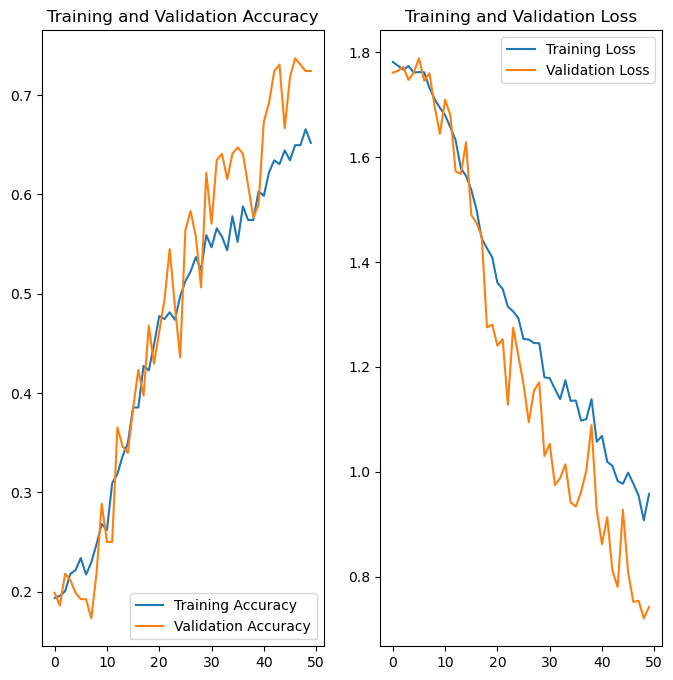

In [33]:
plt.figure(figsize= (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: orallichensdataset
1/1 [==============================] - 1s 929ms/step
predicted label: orallichensdataset


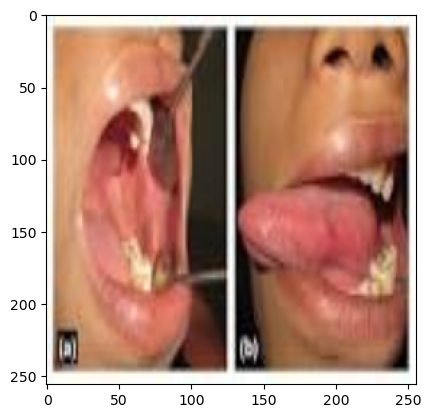

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])